# **ALGORITMO APRIORI - PYSPARK**
---
**UNIVERSIDAD NACIONAL DE SAN ANTONIO ABAD DEL CUSCO**


>**ESCUELA PROFESIONAL :** Ing. Informatica y de Sistemas



> **CURSO :**  Mineria de Datos

> **Integrantes**
* ERICK ANDREW BUSTAMANTE FLORES 🧑
* RONALDINHO VEGA CENTENO OLIVERA 🧑
* ALEX HELDER HUANCARA CCOLQQUE 🧑
* DANIEL EDUARDO SARCO JACINTO 🧑 
* RONALDO QUISPE YAHUIRA 🧑


##**1. INSTALACION DE PYPARK**

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 53.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d398a5596ee207cd4ce6923fdbfcddbdf3916a6393fcd7a159acd8c28c0a802f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


##**2. FUNCIONES UTILIZADAS**



1.   **.map()** es una transformación RDD que se usa para aplicar la función de transformación (lambda) en cada elemento de RDD/DataFrame y devuelve un nuevo RDD.
2.   **.flatMap()** Une todos los datos en un solo RDD/DataFrame después de aplicar la función en cada elemento y devuelve un nuevo RDD/DataFrame respectivamente.
3.   **.distinct()** Lo utilizamos para eliminar los datos repetidos.
4.   **.reduceByKey()** se utiliza para fusionar los valores de cada clave mediante una función de reducción asociativa.
5.  **.min()** Se utiliza para recuperar el menor valore del RDD.
6.   **.filter()** Se utiliza para filtrar los datos del RDD por medio de una definicion.
7.   **.cartesian()** Se utiliza para realizar el producto cartesiano de ambos RDD.



##**3. MODULOS**

In [ ]:
#Suma que nos permite reducir por medio de una clave en el RDD.
def Suma(x, y):
  '''
  Realiza la suma de 2 valores (x + y)
  
  Parameters
  =========
    `x :` Primer valor a sumar (type: int)
    `y :` Segundo valor a sumar (type: int)

  Returns
  =========
    `x+y :` La suma de los datos de entrada (type: int)
  '''
  return x + y 


def EliminarRepetidos(record):
  """
  Elimina los elementos repetidos, ya que apriori reconoce A,B y B,A como iguales
  
  Parameters
  =========
    `record :` Conjunto de datos en un arreglo

  Returns
  =========
    `result o x1 :` Conjutno de datos en un arreglo
          
  """
  if (isinstance(record[0], tuple)):
      x1 = record[0]
      x2 = record[1]
  else:
      x1 = [record[0]]
      x2 = record[1]

  if (any(x == x2 for x in x1) == False):
      a = list(x1)
      a.append(x2)
      a.sort()
      result = tuple(a)
      return result
  else:
      return x1

def FiltroConf(item):
  """
  Se encarga de realizar el filtro de los datos verificando la existencia
  donde por lo menos 1 es diferente.
  
  Parameters
  =========
    `item :` Conjunto de datos (type:tupla)

  Returns
  =========
    `item :` Devuelve el item donde conf x es mayor al conf (type:tupla) 
           
  """
  if len(item[0][0]) > len(item[1][0]):
    if not Verificar(item[0][0], item[1][0]):
      pass
    else:
      return item
  else:
    pass


def Verificar(item_1, item_2):
  """
  Se encarga de comparar que al menos tengan un elemento en comun.
  Parameters
  =========
    `item_1 :` Conjunto de datos (type:Lista)
    `item_2 :` Conjunto de datos (type:Tupla)

  Returns
  =========
    Booleano
          
  """
  if len(item_1) > len(item_2): # confianza de x mayor a y
      return all(any(k == l for k in item_1) for l in item_2)
  else: #confianza de y mayor a x
      return all(any(k == l for k in item_2) for l in item_1)


def Confidence(item):
  """
  Calcula el nivel de confianza de cada datos previamente filtrado
  Parameters
  =========
    `item :` Conjunto de datos (type:tupla)

  Returns
  =========
    Conjunto de datos (type: lista)
          
  """
  parent = set(item[0][0])

  if isinstance(item[1][0], str):
      child = set([item[1][0]])
  else:
      child = set(item[1][0])
  parentSupport = item[0][1]
  childSupport = item[1][1]

  support = (parentSupport / childSupport) * 100

  return list([list(child), list(parent.difference(child)), support])

def print_reglas(reglas):
  """
  Imprime las reglas de asociacion, confidence 

  ej. :       

    REGLA N° 1
    Regla      : [1] => [2, 3]
    Confianza  : 200

    --------
  
  """
  cont=1
  for i in reglas:
    print('REGLA N°',cont)
    print('Regla      :',set(i[0]),"=>",set(i[1]))
    print('Confianza  :',i[2])
    print("____________________________________________")
    cont+=1

##**4. CLASE APRIORI**

1. Encuentro los 1-itemset frecuentes escaneando la base de
datos
2. Mezcla: Encuentro candidatos a k-itemsets frecuentes
combinando pares de (k-1)-itemsets frecuentes que sólo
difieran en su último elemento. (Los itemsets deben estar
ordenados lexicográficamente)
3. Poda: chequeo que los sub-itemsets del candidato sean
frecuentes. Si encuentro algún sub-itemset no frecuente
descarto el candidato por principio Apriori.
4. Conteo de suporte: cuento el soporte del itemset
candidato y chequeo si cumple el criterio minsup. Uso un
árbol hash (hash tree) para hacer el conteo de manera
eficiente.

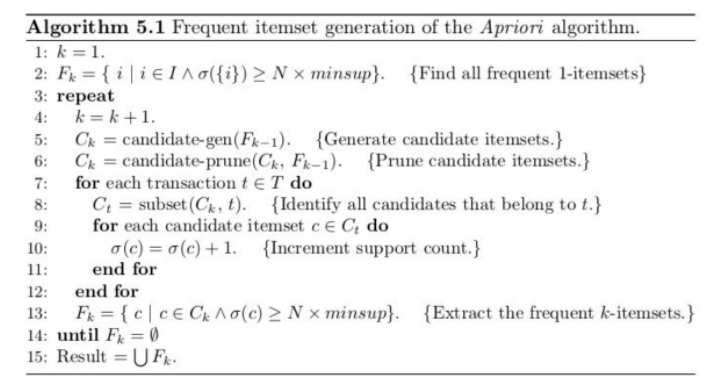

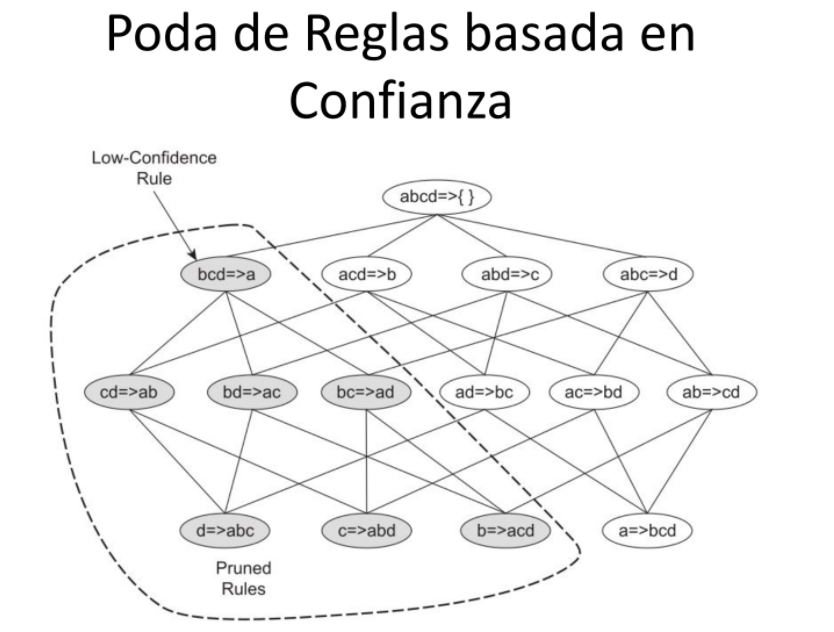

In [ ]:
class Apriori:
    def __init__(self, path, sc, minSupport=2):
        #Definimos nuestras variables iniciales.
        self.confidences = None
        self.path = path

        # Definimos spark context
        self.sc = sc

        # DEfinimos nustro soporte minimo
        self.minSupport = minSupport
        #Creamos un modelo RDD para utilizar las funciones de spark.
        self.raw = self.sc.textFile(self.path) 
        #Map, Aplicamos un split a cada x del RDD para asi
        # tokenizarlor y ponerlos en una lista por medio de las ','.
        self.lblitems = self.raw.map(lambda line: line.split(','))

        #flatMap, Aplicamos un split a cada x del RDD para asi 
        #tokenizarlo por medio de las ',' y tenerlos todo en una lista.
        self.wlitems = self.raw.flatMap(lambda line: line.split(','))

        #distinct(), eliminamos todos aquellos datos que 
        #sean repetidos para asi tener nuestros datos unicos.
        self.uniqueItems = self.wlitems.distinct() 

    def fit(self):
        """
        Se encarga de entrenar el modelo apriori para asi poder determinar el 
        confidence de cada conjunto de datos

        Parameters
        =========

        Returns
        =========
          `confidences :` Conjunto de datos (type: lista)
                  
        """
        #Map, Convertimos nuestros datos en tuplas donde le asignamos a cada 
        #una un 1 el cual representa la vez que aparece en el conjunto de datos.
        supportRdd = self.wlitems.map(lambda item: (item, 1))
        #reduceByKey, aplicamos la funcion suma la cual se encargar
        # de sumar las frecuencias donde tengan la misma clave para
        # asi tener nuestra frecuencia de datos.
        supportRdd = supportRdd.reduceByKey(Suma) 
        #map, creamos una variable la cual tendra unicamente todos los soportes.
        supports = supportRdd.map(lambda item: item[1]) 

        # Definir valor mínimo de soporte

        #ponemos un valor por defecto el cual sera 2 ya que queremos
        # evitar aquellos datos que su frecuencia sea solo 1
        if self.minSupport is 'auto': 
          #Si vemos que se utiliza este dato por defecto entonces calculamos 
          #el soporte minimo de un conjunto de datos
            minSupport = supports.min() 
        else:
          #Si vemos que se utiliza un dato distinto entonces pasamos 
          #a definirlo como el soporte minimo
            minSupport = self.minSupport 

        # Si el soporte mínimo es 1, se tomara el valor de 2 ya que 
        #no se requiere aplicar el algoritmo apriori a frencuencias 1
        minSupport = 2 if minSupport < 2 else minSupport
        #Filter, filtramos nuestros datos con respecto a su soporte en donde
        # solo se toman aquellos que son mayores al soporte minimo
        supportRdd = supportRdd.filter(lambda item: item[1] >= minSupport) 
        #Map, Creamos una tupla la cual tendra un lista 
        #con los datos y los soportes respectivamente.
        baseRdd = supportRdd.map(lambda item: ([item[0]], item[1])) 
        #Map, Creamos una variable donde solo tendra 
        #los datos que cumplen con el soporte
        supportRdd = supportRdd.map(lambda item: item[0]) 

        #ya que tenemos definido nuestra combinada de 1 [a] pasamos 
        #a definir la siguiente que seria combianda de 2 [a,b].
        c = 2
        #Creamos un while para crear las combinada correspondiendte
        while not supportRdd.isEmpty():
          #Cartesian, realizamos el producto cartesiano entre
          # los datos que cumple el soporte con el conjunto de datos unico.
            combined = supportRdd.cartesian(self.uniqueItems) 
            #Map, aplicamos la funcion EliminarRepetidos ya que
            # apriori considera A,B igual a B,A
            combined = combined.map(lambda item: EliminarRepetidos(item)) 
            #Filter, aplocamos la comparacion del tamaño del dato
            # con el tamaño de la combinada lo cual nos permitira 
            #descartar aquellas combinadas mayores o menores a c
            combined = combined.filter(lambda item: len(item) == c) 
            #Aplicamos distinct para eliminar los repetidos.
            combined = combined.distinct()
            #Cartesian, realizamos el producto cartesiano entre 
            #todo el conjunto de datos qie cumplen la combianda
            # de c con de datos existentes en el input
            #nos permite verificar que la combinada existe en
            # por lo menos en alguno de los datos de entrada
            combined_2 = combined.cartesian(self.lblitems)  
            #Filter, filtramos todos aquellos datos que cumplan la funcion all.
            combined_2 = combined_2.filter(lambda item: all(x in item[1] for x in item[0])) 

            #Map, creamos una variable con todos los datos combinados.
            combined_2 = combined_2.map(lambda item: item[0]) 
            #map, creamos una tupla la cual nos permitira
            #saber la frecuencia de dicho dato.
            combined_2 = combined_2.map(lambda item: (item, 1)) 
            #reduceByKey, aplicamos la funcion de suma
            # y asi saber la frecuencia de cada combinada.
            combined_2 = combined_2.reduceByKey(Suma) 
            #filter, filtramos tos aquellos datos que 
            #tiene un soporte mayor o igual al de entrada.
            combined_2 = combined_2.filter(lambda item: item[1] >= minSupport) 

            #Realizamos la combinada de el conjunto de las 
            #frecuencias con la combinada correspondiente.
            baseRdd = baseRdd.union(combined_2) 
            #Realizamos la funcion map para asi guardas todos 
            #los datos que cumplen con el soporte.
            combined_2 = combined_2.map(lambda item: item[0]) 
            supportRdd = combined_2
            #oncrementamos c hasta que se cumplan todas las iteraciones.
            c = c + 1 
        #Cartesian, realizamos el producto cartesiano de baseRDD con BaseRDD.
        sets = baseRdd.cartesian(baseRdd) 
        #Aplicamos el filter a sets el cual utilizare la funcion filtroConf.
        filtered = sets.filter(lambda item: FiltroConf(item))
        #Aplicamos la funcion map y a este mismo le pasamos la funcion 
        #confidence la cual nos permitira ver si se cumple la confidencia o no
        confidences = filtered.map(lambda item: Confidence(item)) 
         #Guardamos la informacion
        self.confidences = confidences

         #Retornamos la confidencia
        return confidences

    def BusquedaEspecifica(self, set, confidence):
        """
        Se encarga de mostrar los datos que cumplen con el nivel de confianza 
        y el dataset

        Parameters
        =========
          `set :` Conjunto de datos para busqueda (type: Lista)
          `confidences :` Valor de confidences a comparar (type:float)

        Returns
        =========
          `filtered :` Conjunto de datos (type: lista)
                
        """
        #Verificamos que el dato de entrada no sea una lista
        if not isinstance(set, list): 
            raise ValueError('For prediction "set" argument should be a list')

        _confidences = self.confidences
        _FiltraBusqueda = self._FiltraBusqueda  
        #Filterer aplicamos la funcion _FiltrarBusqueda la cual nos permitira 
        #recuperar si el confidence se cumple o no.
        filtered = _confidences.filter(lambda x: _FiltraBusqueda(x, set, confidence)) 
        #Retronamos los datos filtrados
        return filtered 

    @staticmethod
    def _FiltraBusqueda(item, set, confidence):
        """
        Se encarga de buscar los datos que cumplen con el confidence y tiene el
        mismo valor de set dentro de los confidence hallados anteriormente.

        Parameters:
        =========
          `item :` Conjunto de datos (type: Lista)
          `set :` Conjunto de datos para comparacion (type: Lista)
          `confidences :` Valor de confidences a comparar (type:float)

        Returns
        =========
          `filtered :` Conjunto de datos (type: lista)
                
        """
        #Recuperamos el primer dato de item
        it = item[0] 
        #PAsamos a ordenarlo
        it.sort() 
        #Ordenmos los datos de set
        set.sort() 
        #Verificamos que cumpla 2 condiciones las cuales son que it == a set y 
        #que el conficende del dato sea mayor al confidence pasado como entrada 
        if it == set and item[2] >= confidence: 
            return item
        else:
            pass

##**5. DEFINICION DE SPARKCONTEXT**

In [ ]:
#Importamos SparkContext. 
from pyspark import SparkContext
sc = SparkContext("local",    "First App")

##**6. EJECUCIÓN**

In [ ]:
import time 
#PAsamos nuestro conjunto de datos, que habiando visto la clase de apriori 
#permite el ingreso de datos separados por comas y sin encabezado
path = "comestibles2.txt"
# Creamos el objeto apriori
#Pasamos el conjunto de datos
#PAsamos el sparkcontext creado
#PAsamos minSupport en auto.
inicio=time.time()
apriori = Apriori(path, sc, minSupport=100)
#Entrenamos nuestro modelo de apriori.
apriori.fit()
fin=time.time()
tiempo = fin-inicio

## **7. DETALLES DE LA EJECUCION**

In [ ]:
print('---------------------------------------------')
print('                     DETALLES                ')
print('---------------------------------------------')
Productos=apriori.uniqueItems.collect()
listas=apriori.lblitems.collect()
reglas=apriori.confidences.collect()
print('| Total de productos distintas              :', len(Productos))
print('| Total de lista de compras(transaccciones) :', len(listas))
print('| Total de reglas generadas          :',len(reglas))
print('| Soporte minimo     :',apriori.minSupport)
print('| Tiempo de ejecucion ---->',round(tiempo,4),'seg.')
print('---------------------------------------------')

---------------------------------------------
                     DETALLES                
---------------------------------------------
| Total de productos distintas              : 167
| Total de lista de compras(transaccciones) : 3500
| Total de reglas generadas          : 50
| Soporte minimo     : 100
| Tiempo de ejecucion ----> 35.6806 seg.
---------------------------------------------


## **8. CREAR DF CON LAS REGLAS Y GUARDAR**

En este trabajo vimos ocmo aplicar la Mineria de Patrones Frecuentes y como aplicamos sobre el algoritmo Apriori. Usamos PySpark para la construcción del algoritmo Apriori desde cero.


Inspeccionemos la siguiente figura para entender cómo funciona Apriori.


Tomamos algunos registros de transacciones en la siguiente figura de 
ejemplo para hacerlo simple y comprensible.

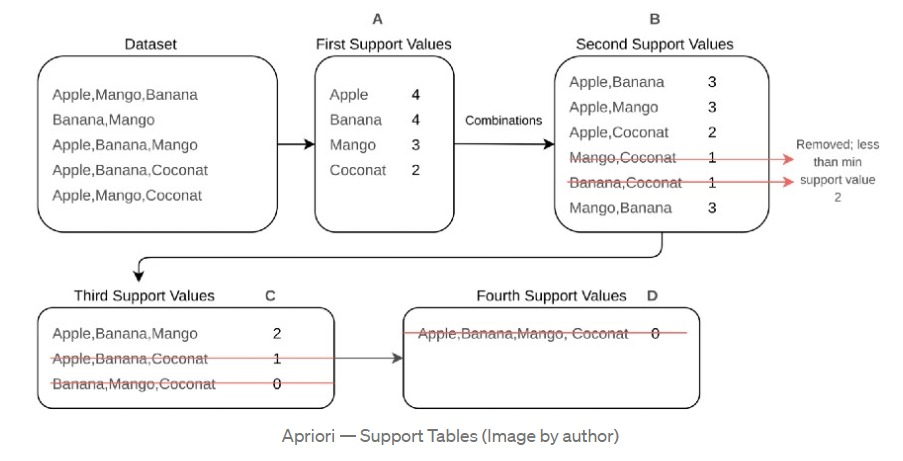

In [ ]:
import pandas as pd
data_array=apriori.confidences.collect()
column_names = ["Antecedente", "Consecuente", "Confidence"]
data_df = pd.DataFrame(data_array,  columns=column_names)
data_df

,Antecedente,Consecuente,Confidence
0,[citrus fruit],[whole milk],39.016393
1,[whole milk],[citrus fruit],13.492063
2,[citrus fruit],[other vegetables],35.409836
3,[yogurt],[whole milk],42.738589
4,[whole milk],[yogurt],23.356009
5,[other vegetables],[citrus fruit],16.023739
6,[tropical fruit],[whole milk],42.307692
7,[whole milk],[tropical fruit],16.213152
8,[whole milk],[other vegetables],28.684807
9,[tropical fruit],[other vegetables],37.278107


In [ ]:
# GUARDAR LAS REGLAS HALLADAS EN UN ARCHIVO CSV
data_df.to_csv('Resultados1.csv')

## **9. BUSQUEDA ESPECIFICA**

In [ ]:
pr = apriori.BusquedaEspecifica(['whole milk'], 10)
result = pr.collect()
print_reglas(result)

REGLA N° 1
Regla      : {'whole milk'} => {'citrus fruit'}
Confianza  : 13.492063492063492
____________________________________________
REGLA N° 2
Regla      : {'whole milk'} => {'yogurt'}
Confianza  : 23.356009070294785
____________________________________________
REGLA N° 3
Regla      : {'whole milk'} => {'tropical fruit'}
Confianza  : 16.213151927437643
____________________________________________
REGLA N° 4
Regla      : {'whole milk'} => {'other vegetables'}
Confianza  : 28.68480725623583
____________________________________________
REGLA N° 5
Regla      : {'whole milk'} => {'bottled water'}
Confianza  : 14.512471655328799
____________________________________________
REGLA N° 6
Regla      : {'whole milk'} => {'curd'}
Confianza  : 11.337868480725625
____________________________________________
REGLA N° 7
Regla      : {'whole milk'} => {'soda'}
Confianza  : 16.666666666666664
____________________________________________
REGLA N° 8
Regla      : {'whole milk'} => {'pastry'}
Confianza  